# ITT-MCT Isotropic Model: LAOS

## Learning Objectives

1. Fit the **ITT-MCT Isotropic (ISM)** model to LAOS data
2. Extract **Fourier harmonics** using `get_laos_harmonics()`
3. Analyze nonlinear response with k-resolved correlators
4. Compare ISM LAOS predictions with Schematic F₁₂

## Prerequisites

- Basic RheoJAX usage
- NB06: Schematic LAOS (recommended for comparison)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~5-8 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~20-30 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTIsotropic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_carbopol_laos,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_isotropic_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: ISM LAOS

### k-Resolved Nonlinear Response

In LAOS, each k-mode experiences periodic cage breaking:
- Small γ₀: Modes stay near equilibrium
- Large γ₀: Periodic decorrelation across k-space

### ISM Advantages for LAOS

- **Quantitative predictions** for hard spheres
- **k-dependent harmonics**: Different modes contribute differently
- **S(k) weighting**: First peak modes dominate stress

## 3. Load Data

In [3]:
# Load LAOS data
OMEGA = 1.0  # rad/s
AMPLITUDE_INDEX = 5  # Moderate amplitude

time_data, strain_data, stress_data = load_carbopol_laos(
    omega=OMEGA, 
    strain_amplitude_index=AMPLITUDE_INDEX
)

gamma_0 = np.max(np.abs(strain_data))

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Strain amplitude: γ₀ ≈ {gamma_0:.4f}")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")

Data points: 1000
Time range: [0.0053, 66.00] s
Strain amplitude: γ₀ ≈ 0.5120
Stress range: [-17.36, 25.30] Pa


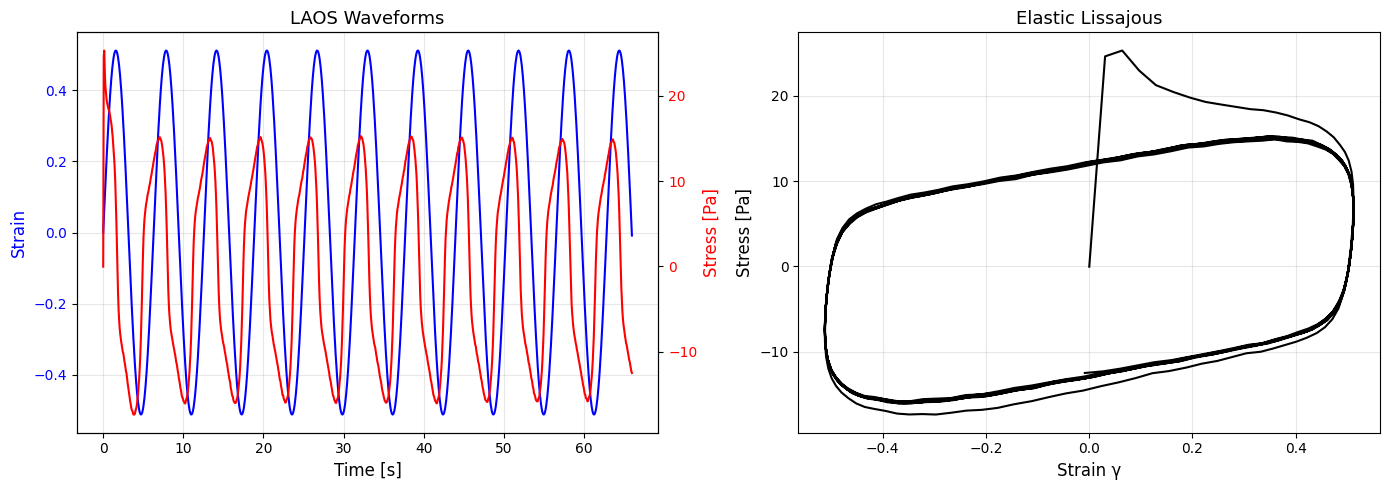

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Waveforms
ax1.plot(time_data, strain_data, 'b-', lw=1.5, label='Strain γ(t)')
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Strain', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1b = ax1.twinx()
ax1b.plot(time_data, stress_data, 'r-', lw=1.5, label='Stress σ(t)')
ax1b.set_ylabel('Stress [Pa]', fontsize=12, color='red')
ax1b.tick_params(axis='y', labelcolor='red')
ax1.set_title('LAOS Waveforms', fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Elastic Lissajous
ax2.plot(strain_data, stress_data, 'k-', lw=1.5)
ax2.set_xlabel('Strain γ', fontsize=12)
ax2.set_ylabel('Stress [Pa]', fontsize=12)
ax2.set_title('Elastic Lissajous', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Model Setup

In [5]:
# Create ISM model
model = ITTMCTIsotropic(phi=0.55)

print("Initial model state:")
print(model)
print()
print_glass_state_summary(model)

Initial model state:
ITTMCTIsotropic(φ=0.550 [glass], n_k=100, sk_source='percus_yevick')


Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress


In [6]:
# Precompile for faster fitting
print("Precompiling model...")
compile_time = model.precompile() if hasattr(model, "precompile") else 0.0
print(f"Precompilation time: {compile_time:.1f} s")

Precompiling model...
Precompilation time: 0.0 s


## 5. NLSQ Fitting

In [7]:
# Fit to LAOS data
param_names = ["phi", "D0", "gamma_c"]

t0 = time.time()
model.fit(time_data, stress_data, test_mode="laos", gamma_0=gamma_0, omega=OMEGA, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in get_isotropic_param_names():
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 941.91 s

Fitted parameters:
  phi        = 0.516
  sigma_d    = 0.001
  D0         = 1e-06
  kBT        = 1.009e-24
  gamma_c    = 0.01


In [8]:
# Compute fit quality
stress_pred = model.predict(time_data, test_mode="laos", gamma_0=gamma_0, omega=OMEGA)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   -33629454441143357931520.000000
  RMSE: 2.127e+12 Pa
  NRMSE: 4986052075500.8906%


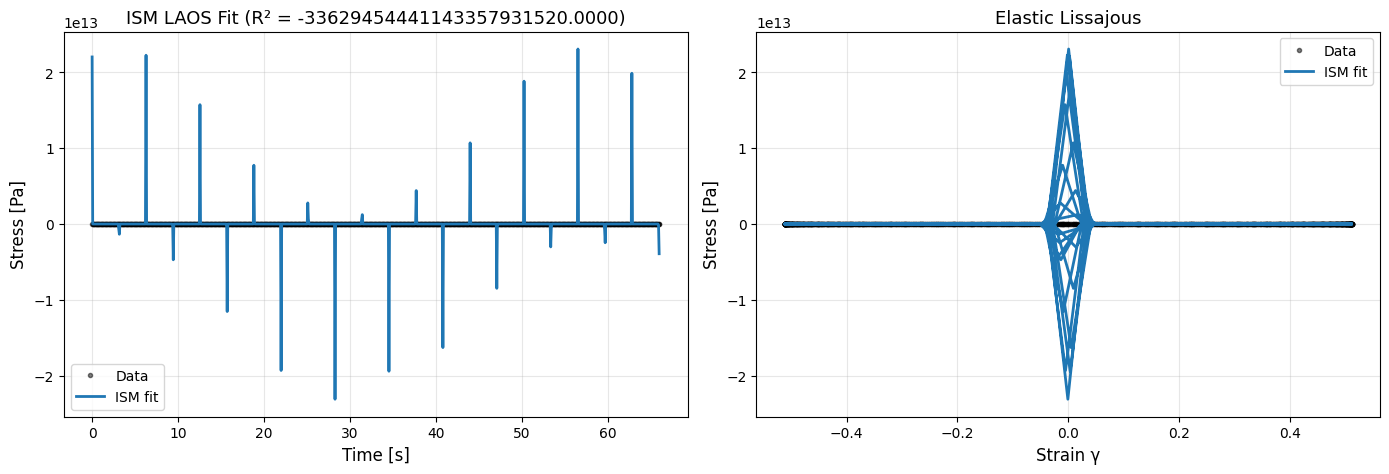

In [9]:
# Plot fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time series
ax1.plot(time_data, stress_data, 'ko', markersize=3, alpha=0.5, label='Data')
ax1.plot(time_data, stress_pred, '-', lw=2, color='C0', label='ISM fit')
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Stress [Pa]', fontsize=12)
ax1.set_title(f'ISM LAOS Fit (R² = {metrics["R2"]:.4f})', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Lissajous comparison
ax2.plot(strain_data, stress_data, 'ko', markersize=3, alpha=0.5, label='Data')
strain_pred = gamma_0 * np.sin(OMEGA * time_data)
ax2.plot(strain_pred, stress_pred, '-', lw=2, color='C0', label='ISM fit')
ax2.set_xlabel('Strain γ', fontsize=12)
ax2.set_ylabel('Stress [Pa]', fontsize=12)
ax2.set_title('Elastic Lissajous', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Fourier Harmonic Analysis

In [10]:
# Extract Fourier harmonics
time_fine = np.linspace(0, 4 * np.pi / OMEGA, 500)

sigma_prime, sigma_double_prime = model.get_laos_harmonics(
    time_fine, 
    gamma_0=gamma_0, 
    omega=OMEGA,
    n_harmonics=5
)

print("ISM LAOS Fourier Harmonics")
print("=" * 50)
print(f"{'Harmonic':>10s}  {'σ\' (in-phase)':>15s}  {'σ\"(out-phase)':>15s}  {'Ratio to 1st':>12s}")
print("-" * 50)

for i, n in enumerate([1, 3, 5, 7, 9]):
    if i < len(sigma_prime):
        sp = sigma_prime[i]
        spp = sigma_double_prime[i]
        ratio = np.sqrt(sp**2 + spp**2) / np.sqrt(sigma_prime[0]**2 + sigma_double_prime[0]**2)
        print(f"{n:>10d}  {sp:>15.4g}  {spp:>15.4g}  {ratio:>12.4f}")

ISM LAOS Fourier Harmonics
  Harmonic    σ' (in-phase)    σ"(out-phase)  Ratio to 1st
--------------------------------------------------
         1        1.027e+09        1.016e+12        1.0000
         3         3.08e+09        1.015e+12        0.9992
         5        5.125e+09        1.013e+12        0.9977
         7        7.159e+09        1.011e+12        0.9955
         9        9.176e+09        1.008e+12        0.9924


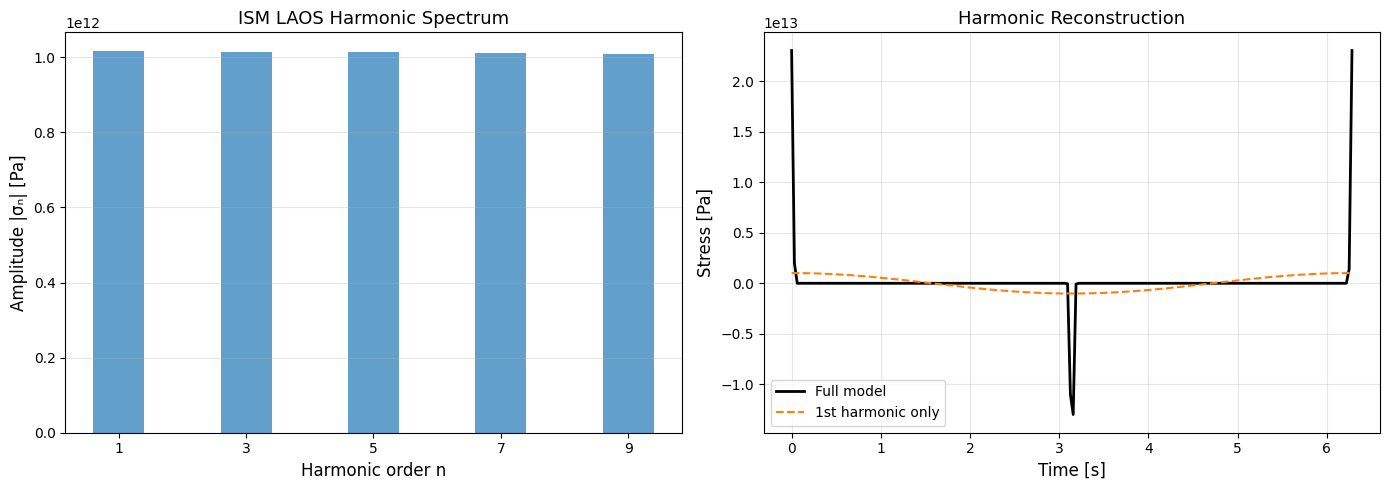

In [11]:
# Visualize harmonics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Harmonic amplitudes
harmonics = [1, 3, 5, 7, 9][:len(sigma_prime)]
amplitudes = np.sqrt(np.array(sigma_prime)**2 + np.array(sigma_double_prime)**2)
ax1.bar(harmonics, amplitudes, color='C0', alpha=0.7)
ax1.set_xlabel('Harmonic order n', fontsize=12)
ax1.set_ylabel('Amplitude |σₙ| [Pa]', fontsize=12)
ax1.set_title('ISM LAOS Harmonic Spectrum', fontsize=13)
ax1.set_xticks(harmonics)
ax1.grid(True, alpha=0.3, axis='y')

# Right: Reconstruct stress
t_recon = np.linspace(0, 2*np.pi/OMEGA, 200)
sigma_1 = sigma_prime[0] * np.sin(OMEGA * t_recon) + sigma_double_prime[0] * np.cos(OMEGA * t_recon)
sigma_full = model.predict(t_recon, test_mode="laos", gamma_0=gamma_0, omega=OMEGA)

ax2.plot(t_recon, sigma_full, 'k-', lw=2, label='Full model')
ax2.plot(t_recon, sigma_1, '--', lw=1.5, color='C1', label='1st harmonic only')
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Stress [Pa]', fontsize=12)
ax2.set_title('Harmonic Reconstruction', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Bayesian Inference

In [12]:
try:
    # Prepare warm-start
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    
    print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        stress_data,
        test_mode="laos",
        gamma_0=gamma_0,
        omega=OMEGA,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:Missing 'model_function' method for Bayesian inference


ERROR:rheojax.core.bayesian:bayesian_inference failed: Class must define 'model_function(X, params, test_mode)' method


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 457, in fit_bayesian
    result = super().fit_bayesian(
        X,
    ...<7 lines>...
        **nuts_kwargs,
    )
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 919, in fit_bayesian
    self._validate_bayesian_requirements()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 285, in _validate_bayesian_requirements
    raise AttributeError(
        "Class must define 'model_function(X, params, test_mode)' method"
    )
AttributeError: Class must define 'model_function(X, params, test_mode)' method


Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: Class must define 'model_function(X, params, test_mode)' method
NLSQ results are reported above.


In [13]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (ISM LAOS)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 8. Summary

In [16]:
print("ISM LAOS Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nLAOS Parameters:")
print(f"  Strain amplitude: γ₀ = {gamma_0:.4f}")
print(f"  Angular frequency: ω = {OMEGA} rad/s")
print(f"  Critical strain: γc = {model.parameters.get_value('gamma_c'):.4f}")
if len(sigma_prime) > 1:
    I3_I1 = np.sqrt(sigma_prime[1]**2 + sigma_double_prime[1]**2) / \
            np.sqrt(sigma_prime[0]**2 + sigma_double_prime[0]**2)
    print(f"  Third harmonic ratio: I₃/I₁ = {I3_I1:.4f}")

ISM LAOS Summary

Glass Transition State
State: GLASS
Volume fraction: phi = 0.5160
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress

LAOS Parameters:
  Strain amplitude: γ₀ = 0.5120
  Angular frequency: ω = 1.0 rad/s
  Critical strain: γc = 0.0100
  Third harmonic ratio: I₃/I₁ = 0.9992


## 9. Save Results

In [17]:
# Save results
save_itt_mct_results(model, result, "isotropic", "laos", param_names)
print("\nISM LAOS results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/isotropic/laos/
  nlsq_params_laos.json: 3 parameters

ISM LAOS results saved.


## Key Takeaways

1. **ISM LAOS** provides k-resolved nonlinear analysis

2. **Fourier harmonics** extracted via `get_laos_harmonics()`

3. **Third harmonic ratio** I₃/I₁ quantifies nonlinearity

4. **S(k) weighting** determines harmonic contributions

### Tutorial Series Complete

This concludes the ITT-MCT tutorial series covering:
- **Schematic F₁₂**: NB01-NB06
- **Isotropic ISM**: NB07-NB12